### The Data
This book serves to load the data and get a understanding for it. Basic feature engineering and selection will be performed using a basic CatBoost model (Gradient Boosting on Decision Trees library).

Note: this book will only consider data from the following csv files: train, test and structures


In [1]:
# OK
import pandas as pd

input_folder = './input'

train = pd.read_csv(f'{input_folder}/train.csv')
#test = pd.read_csv(f'{input_folder}/test.csv')
#structures = pd.read_csv(f'{input_folder}/structures.csv')

In [ ]:
# OK
f'Train shape: {train.shape}'

In [ ]:
# OK
train.head()

In [ ]:
# OK
f'Test shape: {test.shape}'

In [ ]:
# OK
test.head()

In [ ]:
# OK
f'Structures shape: {structures.shape}'

In [ ]:
# OK
structures.head()

In [ ]:
# OK
print(f"There are {train['molecule_name'].nunique()} distinct molecules in train data.")
print(f"There are {test['molecule_name'].nunique()} distinct molecules in test data.")
print(f"Largest molecule contains upto {max(train['atom_index_0'].nunique(), train['atom_index_1'].nunique())} atoms.")
print(f"There are {train['type'].nunique()} unique coupling types: {train['type'].unique()}")
print(f"There are {structures['atom'].nunique()} unique atom types: {structures['atom'].unique()}")

In [ ]:
# OK
train_molecule_set = set(train['molecule_name'].unique())
test_molecule_set = set(test['molecule_name'].unique())
struct_molecule_set = set(structures['molecule_name'].unique())

molecule_overlap_test_train = train_molecule_set.intersection(test_molecule_set)
print(f"Molecule overlap between training and test data sets: {len(molecule_overlap_test_train)}")

molecule_overlap_train_in_struct = train_molecule_set.intersection(struct_molecule_set)
print(f"Train molecules described in structures file: {len(molecule_overlap_train_in_struct)*100/len(train_molecule_set)}%")

molecule_overlap_test_in_struct = test_molecule_set.intersection(struct_molecule_set)
print(f"Test molecules described in structures file: {len(molecule_overlap_test_in_struct)*100/len(test_molecule_set)}%")

#### Any missing values?

In [ ]:
# OK

import numpy as np

pd.set_option('use_inf_as_na', True)

# replace field that's entirely space (or empty) with NaN
train=train.replace(r'^\s*$', np.nan, regex=True)
test=test.replace(r'^\s*$', np.nan, regex=True)
structures=structures.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
# OK
train.isna().any()

In [ ]:
# OK
test.isna().any()

In [ ]:
# OK
structures.isna().any()

#### Merging data sources into one training data set and one test data set 

Code for joining data is from this kernel: https://www.kaggle.com/seriousran/just-speed-up-calculate-distance-from-benchmark

In [ ]:
# OK
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

In [ ]:
# OK
train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

In [ ]:
train.head()

In [ ]:
# OK
test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [ ]:
test.head()

### Feature engineering
#### Distances between atoms

In [ ]:
# OK
def add_distances(df):
    df['dx']=df['x_1']-df['x_0']
    df['dy']=df['y_1']-df['y_0']
    df['dz']=df['z_1']-df['z_0']
    df['dx2']=df['dx']**2
    df['dy2']=df['dy']**2
    df['dz2']=df['dz']**2
    df['distance']=(df['dx2'] + df['dy2'] + df['dz2'])**(1/2)
    return df

In [ ]:
# OK
train=add_distances(train)
test=add_distances(test)

#### Handling Category data

TODO: check this
For the above columns I will consider atom_index's ordinal data together with no_of_atomic_bond_distances. I will argue that atom's are pure labels, that is, nominal data.

LabelEncoder could be used for the ordinal data but as they are already ordered integers we will leave them be. One Hot Encoding is used for nominal data.

In [ ]:
# OK
train_type = pd.get_dummies(train['type'])
test_type = pd.get_dummies(test['type'])

train = pd.concat([train, train_type], axis=1)
test = pd.concat([test, test_type], axis=1)

In [ ]:
train_atom_0 = pd.get_dummies(train['atom_0'], prefix='atom_0')
test_atom_0 = pd.get_dummies(test['atom_0'], prefix='atom_0')

train = pd.concat([train, train_atom_0], axis=1)
test = pd.concat([test, test_atom_0], axis=1)

train_atom_1 = pd.get_dummies(train['atom_1'], prefix='atom_1')
test_atom_1 = pd.get_dummies(test['atom_1'], prefix='atom_1')

train = pd.concat([train, train_atom_1], axis=1)
test = pd.concat([test, test_atom_1], axis=1)


In [ ]:
# OK

from sklearn.preprocessing import LabelEncoder

#train['atom_0'] = train['atom_0'].astype("category").cat.codes
#train['atom_1'] = train['atom_1'].astype("category").cat.codes
#test['atom_0'] = test['atom_0'].astype("category").cat.codes
#test['atom_1'] = test['atom_1'].astype("category").cat.codes

# Moved labelcoder and fit outside loop to share same values for all atoms?

lbl = LabelEncoder()
lbl.fit(list(train['atom_0'].values) + list(test['atom_0'].values) + list(train['atom_1'].values) + list(test['atom_1'].values))
for col in ['atom_0', 'atom_1']:
    train[col] = lbl.transform(list(train[col].values))
    test[col] = lbl.transform(list(test[col].values))

#### Overview of current data

In [ ]:
train.head(10)

In [ ]:
test.head(10)

#### Make a copy of data for first training

In [ ]:
# OK
# Keep the test ID's
test_ids = test['id']

In [ ]:
# OK
columns_to_use_v1 = [
    'atom_index_0',
    'atom_index_1',    
    #'atom_0',
    'x_0',
    'y_0',
    'z_0',
    #'atom_1',
    'x_1',
    'y_1',
    'z_1',
    'dx',
    'dy',
    'dz',
    'dx2',
    'dy2',
    'dz2',
    'distance',
    '1JHC',
    '1JHN',
    '2JHC',
    '2JHH',
    '2JHN',
    '3JHC',
    '3JHH',
    '3JHN',
    'atom_0_H',
    'atom_1_C',
    'atom_1_H',
    'atom_1_N',
]

In [ ]:
# OK
train_X = train[columns_to_use_v1].copy()
train_y = train['scalar_coupling_constant']
test_X = test[columns_to_use_v1].copy()

### Data splitting

In [ ]:
# OK
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, random_state = 13, test_size = 0.25)


### The model

In [ ]:
# OK
from catboost import CatBoostRegressor

In [ ]:
# OK
model_cat = CatBoostRegressor(iterations=2000, depth= 13, random_seed = 23, task_type = "GPU", devices='0')

In [ ]:
# OK
model_cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), logging_level='Verbose', plot=True)
# 3.4702
# 3.4705

# 3.4706 label encoding
# 3.4648 One hot encoding

##### Quick look at feature importance

In [ ]:
# This is for OHE of type and Label encoding of atom_0 and atom_1
import matplotlib.pyplot as plt

fea_imp = pd.DataFrame({'col': train_X.columns, 'imp': model_cat.feature_importances_})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [ ]:
# This is for OHE of type and Label encoding of atom_0 and atom_1
fea_imp.sort_values(by='imp', ascending=False)

In [ ]:
# This is for OHE of type, atom_0 and atom_1
import matplotlib.pyplot as plt

fea_imp = pd.DataFrame({'col': train_X.columns, 'imp': model_cat.feature_importances_})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [ ]:
# This is for OHE of type, atom_0 and atom_1
fea_imp.sort_values(by='imp', ascending=False)

In [ ]:
# OK
y_pred = model_cat.predict(X_valid)

In [ ]:
# OK
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

print("Variance_Score(cat_Regressor)\t:"+str(explained_variance_score(y_valid,y_pred)))
print("Mean_Absolute_Error(cat_Regressor)\t:"+str(mean_absolute_error(y_valid,y_pred)))
print("Mean_Squared_Error(cat_Regressor)\t:"+str(mean_squared_error(y_valid,y_pred)))
print("R2-Score(cat_Regressor)\t:"+str(r2_score(y_valid,y_pred)))

Label Encoding:
- Variance_Score(cat_Regressor)	:0.9901432875300997
- Mean_Absolute_Error(cat_Regressor)	:2.117706540371986
- Mean_Squared_Error(cat_Regressor)	:12.045393776077965
- R2-Score(cat_Regressor)	:0.9901432590342369
<BR>
    
One Hot Encoding 
- Variance_Score(cat_Regressor)	:0.9901764644318259
- Mean_Absolute_Error(cat_Regressor)	:2.1160949813305647
- Mean_Squared_Error(cat_Regressor)	:12.004858234655817
- R2-Score(cat_Regressor)	:0.9901764292517602

In [ ]:
# OK
import numpy as np

predictions = model_cat.predict(test_X)

print(f'Mean: {np.mean(predictions)}')
print(f'std: {np.std(predictions)}')
print(f'Median: {np.median(predictions)}')
print(f'Min: {np.amin(predictions, axis = 0)}')
print(f'Max: {np.amax(predictions, axis = 0)}')


Label Encoding
- Mean: 15.88686737376035
- std: 34.660710108935
- Median: 2.629095976719184
- Min: -21.341563433735075
- Max: 220.7949596659139
<BR>
  
One Hot Encoding
- Mean: 15.88702962893186
- std: 34.66088572045097
- Median: 2.625737756448414
- Min: -21.282020727288177
- Max: 218.22497992595754

In [ ]:
# OK
rows_to_compare = [0, 1, 89, 368, 3434, 12345, 100000, 2500000]
print(predictions[rows_to_compare])

Label Encoding
<BR>
[  2.59968011 156.2923657    3.26403273  83.85696981  86.61881557
   2.80670743  -8.41252018   0.27499807]
   
One Hot Encoding
<BR>
[  2.75261998 146.15409166   3.17457195  84.17543889  86.48490323
   2.85781352  -8.41580391   0.15665672]

### Submit scores!


Label Encoding
<BR>
0.655
    
One Hot Encoding
<BR>
0.654

### Let's try a simple physical model

In [ ]:
columns_to_use_v2 = [
    'atom_index_0',
    'atom_index_1',    
    'distance',
    '1JHC',
    '1JHN',
    '2JHC',
    '2JHH',
    '2JHN',
    '3JHC',
    '3JHH',
    '3JHN',
    'atom_0_H',
    'atom_1_C',
    'atom_1_H',
    'atom_1_N',
]

In [ ]:
train_X_v2 = train[columns_to_use_v2].copy()
train_y_v2 = train['scalar_coupling_constant']
test_X_v2 = test[columns_to_use_v2].copy()

In [ ]:
# OK
from sklearn.model_selection import train_test_split

X_train_v2, X_valid_v2, y_train_v2, y_valid_v2 = train_test_split(train_X_v2, train_y_v2, random_state = 13, test_size = 0.25)

In [ ]:
model_cat_simple = CatBoostRegressor(iterations=2000, depth= 13, random_seed = 23, task_type = "GPU", devices='0')

In [ ]:
model_cat_simple.fit(X_train_v2, y_train_v2, eval_set=(X_valid_v2, y_valid_v2), logging_level='Verbose', plot=True)
# with columns_to_use_v2 we got 4.3949

In [ ]:
# This is for OHE of type, atom_0 and atom_1
import matplotlib.pyplot as plt

fea_imp = pd.DataFrame({'col': train_X_v2.columns, 'imp': model_cat_simple.feature_importances_})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');

In [ ]:
y_pred_v2 = model_cat_simple.predict(X_valid_v2)

In [ ]:
print("Variance_Score(cat_Regressor)\t:"+str(explained_variance_score(y_valid_v2,y_pred_v2)))
print("Mean_Absolute_Error(cat_Regressor)\t:"+str(mean_absolute_error(y_valid_v2,y_pred_v2)))
print("Mean_Squared_Error(cat_Regressor)\t:"+str(mean_squared_error(y_valid_v2,y_pred_v2)))
print("R2-Score(cat_Regressor)\t:"+str(r2_score(y_valid_v2,y_pred_v2)))

In [ ]:
predictions_v2 = model_cat_simple.predict(test_X_v2)

print(f'Mean: {np.mean(predictions_v2)}')
print(f'std: {np.std(predictions_v2)}')
print(f'Median: {np.median(predictions_v2)}')
print(f'Min: {np.amin(predictions_v2, axis = 0)}')
print(f'Max: {np.amax(predictions_v2, axis = 0)}')

In [ ]:
rows_to_compare = [0, 1, 89, 368, 3434, 12345, 100000, 2500000]
print(predictions[rows_to_compare])

### All sorts of features and aggregated features
With this approach we are not really considering the nature of the physical problem but rather assuming an approach that follows one simple rule: 
- The more features, of any kind, the better for the model


In [ ]:
# OK
train_many_features_X = train.copy()
train_many_features_y = train['scalar_coupling_constant']
test_many_features_X = test.copy()

train_many_features_X = train_many_features_X.drop('scalar_coupling_constant', axis=1)


In [ ]:
train_many_features_X.columns

In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                c_prec = df[col].apply(lambda x: np.finfo(x).precision).max()
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max and c_prec == np.finfo(np.float16).precision:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max and c_prec == np.finfo(np.float32).precision:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
                    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df
    

In [ ]:
def create_features(df):
    df['molecule_couples'] = df.groupby('molecule_name')['id'].transform('count')
    df['molecule_dist_mean'] = df.groupby('molecule_name')['distance'].transform('mean')
    df['molecule_dist_min'] = df.groupby('molecule_name')['distance'].transform('min')
    df['molecule_dist_max'] = df.groupby('molecule_name')['distance'].transform('max')
    df['molecule_dist_std'] = df.groupby('molecule_name')['distance'].transform('std')
    df['atom_0_couples_count'] = df.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
    df['atom_1_couples_count'] = df.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

    num_cols = ['distance'] # 'dx', 'dy', 'dz'
    cat_cols = ['atom_index_0', 'atom_index_1', 'type',]
    aggs = ['mean', 'std', 'max', 'min']
    for col in cat_cols:
        df[f'molecule_{col}_count'] = df.groupby('molecule_name')[col].transform('count')

    for cat_col in cat_cols:
        for num_col in num_cols:
            for agg in aggs:
                df[f'molecule_{cat_col}_{num_col}_{agg}'] = df.groupby(['molecule_name', cat_col])[num_col].transform(agg)
                df[f'molecule_{cat_col}_{num_col}_{agg}_diff'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] - df[num_col]
                df[f'molecule_{cat_col}_{num_col}_{agg}_div'] = df[f'molecule_{cat_col}_{num_col}_{agg}'] / df[num_col]

    df = reduce_mem_usage(df)
    return df

In [6]:
del train
del test
del structures
del train_many_features_X
del train_many_features_y
#del test_many_features_X

import gc
gc.collect()

37

In [9]:
import gc

del train_many_features_X

gc.collect()

0

In [ ]:
train_many_features_X = create_features(train_many_features_X)

In [ ]:
test_many_features_X = create_features(test_many_features_X)

In [1]:
import feather
 
path = 'train_many_features_X.feather'
 
#feather.write_dataframe(train_many_features_X, path)
train_many_features_X = feather.read_dataframe(path)

#train_many_features_X = train_many_features_X.drop('id', axis=1)
#train_many_features_X = train_many_features_X.drop('molecule_name', axis=1)
#train_many_features_X = train_many_features_X.drop('atom_0', axis=1)
#train_many_features_X = train_many_features_X.drop('atom_1', axis=1)
#train_many_features_X = train_many_features_X.drop('type', axis=1)

#feather.write_dataframe(train_many_features_X, path)


In [6]:
path = 'test_many_features_X.feather'
 
#feather.write_dataframe(test_many_features_X, path)
test_many_features_X = feather.read_dataframe(path)

#test_many_features_X = test_many_features_X.drop('id', axis=1)
#test_many_features_X = test_many_features_X.drop('molecule_name', axis=1)
#test_many_features_X = test_many_features_X.drop('atom_0', axis=1)
#test_many_features_X = test_many_features_X.drop('atom_1', axis=1)
#test_many_features_X = test_many_features_X.drop('type', axis=1)

#feather.write_dataframe(test_many_features_X, path)

In [2]:
#train_many_features_y = train['scalar_coupling_constant']
#print(train_many_features_y.head)
path = 'train_many_features_y.feather'
 
#feather.write_dataframe(pd.DataFrame(train_many_features_y), path)
train_many_features_y = feather.read_dataframe(path)

In [3]:
from sklearn.model_selection import train_test_split

X_train_many_features, X_valid_many_features, y_train_many_features, y_valid_many_features = train_test_split(train_many_features_X, train_many_features_y, random_state = 13, test_size = 0.25)

import gc

del train_many_features_X
del train_many_features_y

gc.collect()

0

In [13]:
from catboost import CatBoostRegressor

model_cat_many_features = CatBoostRegressor(iterations=100, depth= 13, random_seed = 23, task_type = "GPU", devices='0')

In [7]:
X_train_many_features.head()

,id,molecule_name,atom_index_0,atom_index_1,type,atom_0,x_0,y_0,z_0,atom_1,...,molecule_type_distance_mean_div,molecule_type_distance_std,molecule_type_distance_std_diff,molecule_type_distance_std_div,molecule_type_distance_max,molecule_type_distance_max_diff,molecule_type_distance_max_div,molecule_type_distance_min,molecule_type_distance_min_diff,molecule_type_distance_min_div
1842207,1842207,dsgdb9nsd_059231,13,0,3JHC,H,1.861250,-0.058599,-1.288211,C,...,1.085723,0.331517,-2.460233,0.118749,3.497987,0.706237,1.252973,2.608788,-0.182961,0.934464
2562820,2562820,dsgdb9nsd_077574,18,5,3JHC,H,1.476124,-0.086016,-1.641320,C,...,1.051447,0.327790,-2.648035,0.110151,3.614739,0.638915,1.214702,2.367343,-0.608481,0.795525
385754,385754,dsgdb9nsd_013099,9,2,2JHC,H,0.676960,-0.921399,-0.385965,C,...,1.005606,0.096594,-2.106302,0.043849,2.297906,0.095009,1.043129,1.922445,-0.280451,0.872690
3149003,3149003,dsgdb9nsd_091810,18,4,3JHC,H,1.279149,-3.150471,2.516222,C,...,0.982856,0.322241,-2.801311,0.103165,3.544505,0.420952,1.134767,2.581478,-0.542075,0.826456
156015,156015,dsgdb9nsd_006160,15,3,3JHC,H,-4.093235,-3.182593,0.515818,C,...,0.840387,0.326297,-3.194842,0.092668,3.523049,0.001909,1.000542,2.527799,-0.993340,0.717892


In [12]:
X_train_many_features = X_train_many_features.drop('id', axis=1)
X_train_many_features = X_train_many_features.drop('molecule_name', axis=1)
X_train_many_features = X_train_many_features.drop('atom_0', axis=1)
X_train_many_features = X_train_many_features.drop('atom_1', axis=1)
X_train_many_features = X_train_many_features.drop('type', axis=1)

X_valid_many_features = X_valid_many_features.drop('id', axis=1)
X_valid_many_features = X_valid_many_features.drop('molecule_name', axis=1)
X_valid_many_features = X_valid_many_features.drop('atom_0', axis=1)
X_valid_many_features = X_valid_many_features.drop('atom_1', axis=1)
X_valid_many_features = X_valid_many_features.drop('type', axis=1)

#test_many_features_X = test_many_features_X.drop('id', axis=1)
#test_many_features_X = test_many_features_X.drop('molecule_name', axis=1)
#test_many_features_X = test_many_features_X.drop('atom_0', axis=1)
#test_many_features_X = test_many_features_X.drop('atom_1', axis=1)
#test_many_features_X = test_many_features_X.drop('type', axis=1)


In [15]:
gc.collect()

56

In [14]:
model_cat_many_features.fit(X_train_many_features, y_train_many_features, eval_set=(X_valid_many_features, y_valid_many_features), logging_level='Verbose', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 37.2511447	test: 37.2889637	best: 37.2889637 (0)	total: 129ms	remaining: 12.8s
1:	learn: 36.1478266	test: 36.1847720	best: 36.1847720 (1)	total: 257ms	remaining: 12.6s
2:	learn: 35.0792127	test: 35.1153540	best: 35.1153540 (2)	total: 381ms	remaining: 12.3s
3:	learn: 34.0417198	test: 34.0771281	best: 34.0771281 (3)	total: 512ms	remaining: 12.3s
4:	learn: 33.0353710	test: 33.0701188	best: 33.0701188 (4)	total: 640ms	remaining: 12.2s
5:	learn: 32.0602134	test: 32.0942010	best: 32.0942010 (5)	total: 756ms	remaining: 11.8s
6:	learn: 31.1135547	test: 31.1469123	best: 31.1469123 (6)	total: 881ms	remaining: 11.7s
7:	learn: 30.1980910	test: 30.2307922	best: 30.2307922 (7)	total: 1s	remaining: 11.5s
8:	learn: 29.3095779	test: 29.3416236	best: 29.3416236 (8)	total: 1.13s	remaining: 11.5s
9:	learn: 28.4479055	test: 28.4792232	best: 28.4792232 (9)	total: 1.25s	remaining: 11.3s
10:	learn: 27.6107859	test: 27.6416152	best: 27.6416152 (10)	total: 1.37s	remaining: 11.1s
11:	learn: 26.7999500	

94:	learn: 3.7926734	test: 3.8059117	best: 3.8059117 (94)	total: 11.8s	remaining: 623ms
95:	learn: 3.7513484	test: 3.7646095	best: 3.7646095 (95)	total: 12s	remaining: 498ms
96:	learn: 3.7129025	test: 3.7261573	best: 3.7261573 (96)	total: 12.1s	remaining: 374ms
97:	learn: 3.6770117	test: 3.6902305	best: 3.6902305 (97)	total: 12.2s	remaining: 249ms
98:	learn: 3.6421756	test: 3.6554224	best: 3.6554224 (98)	total: 12.3s	remaining: 124ms
99:	learn: 3.6092478	test: 3.6224622	best: 3.6224622 (99)	total: 12.4s	remaining: 0us
bestTest = 3.622462183
bestIteration = 99
Shrink model to first 100 iterations.


In [17]:
y_pred_many_features = model_cat_many_features.predict(X_valid_many_features)

In [18]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

print("Variance_Score(cat_Regressor)\t:"+str(explained_variance_score(y_valid_many_features,y_pred_many_features)))
print("Mean_Absolute_Error(cat_Regressor)\t:"+str(mean_absolute_error(y_valid_many_features,y_pred_many_features)))
print("Mean_Squared_Error(cat_Regressor)\t:"+str(mean_squared_error(y_valid_many_features,y_pred_many_features)))
print("R2-Score(cat_Regressor)\t:"+str(r2_score(y_valid_many_features,y_pred_many_features)))

Variance_Score(cat_Regressor)	:0.9972875810846135
Mean_Absolute_Error(cat_Regressor)	:1.1697047655787505
Mean_Squared_Error(cat_Regressor)	:3.3147063082513712
R2-Score(cat_Regressor)	:0.9972875771381671


In [22]:
predictions = model_cat_many_features.predict(test_many_features_X)

submission = pd.read_csv('./input/sample_submission.csv')
submission['scalar_coupling_constant'] = predictions
submission.to_csv('many_features_CAT.csv', index=False)

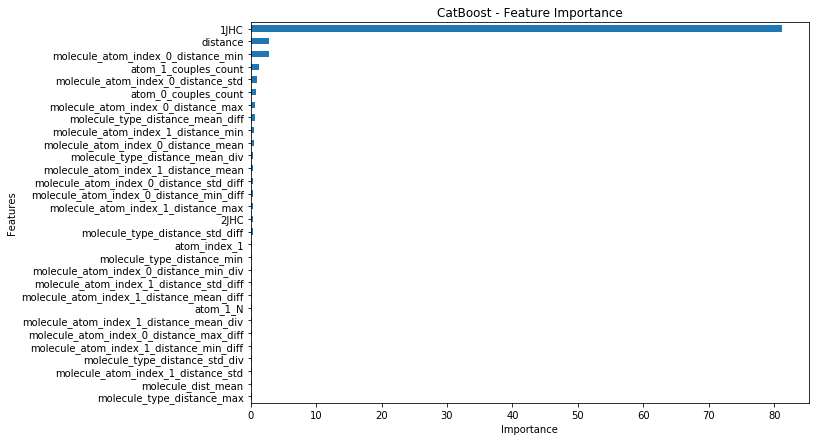

In [24]:
import matplotlib.pyplot as plt

fea_imp = pd.DataFrame({'col': X_train_many_features.columns, 'imp': model_cat_many_features.feature_importances_})
fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
fea_imp.plot(kind='barh', x='col', y='imp', figsize=(10, 7), legend=None)
plt.title('CatBoost - Feature Importance')
plt.ylabel('Features')
plt.xlabel('Importance');


In [4]:
from catboost import CatBoostRegressor

model_cat_many_features_v2 = CatBoostRegressor(iterations=4200,  gpu_ram_part=0.95, gpu_cat_features_storage='CpuPinnedMemory', depth= 15, random_seed = 23, task_type = "GPU", devices='0')
# 1.457 with iterations=5000, depth= 15 - EXPLODED WITH 'BAD ALLOCATION'
# 1.479 with iterations=4500, depth= 15 - EXPLODED WITH 'BAD ALLOCATION'
# Kernel explosion with depth 16 - forget it!
# 1.494 with iterations=4200, depth= 15


In [5]:
model_cat_many_features_v2.fit(X_train_many_features, y_train_many_features, eval_set=(X_valid_many_features, y_valid_many_features), logging_level='Verbose', plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 37.2504739	test: 37.2882886	best: 37.2882886 (0)	total: 257ms	remaining: 18m
1:	learn: 36.1481428	test: 36.1851395	best: 36.1851395 (1)	total: 508ms	remaining: 17m 46s
2:	learn: 35.0773180	test: 35.1135510	best: 35.1135510 (2)	total: 745ms	remaining: 17m 22s
3:	learn: 34.0386523	test: 34.0741202	best: 34.0741202 (3)	total: 992ms	remaining: 17m 21s
4:	learn: 33.0342686	test: 33.0691632	best: 33.0691632 (4)	total: 1.24s	remaining: 17m 22s
5:	learn: 32.0576408	test: 32.0919234	best: 32.0919234 (5)	total: 1.49s	remaining: 17m 22s
6:	learn: 31.1123477	test: 31.1460406	best: 31.1460406 (6)	total: 1.74s	remaining: 17m 23s
7:	learn: 30.1934657	test: 30.2264462	best: 30.2264462 (7)	total: 2.01s	remaining: 17m 32s
8:	learn: 29.3020741	test: 29.3343282	best: 29.3343282 (8)	total: 2.25s	remaining: 17m 27s
9:	learn: 28.4381337	test: 28.4698721	best: 28.4698721 (9)	total: 2.49s	remaining: 17m 24s
10:	learn: 27.6004032	test: 27.6316186	best: 27.6316186 (10)	total: 2.73s	remaining: 17m 21s
1

91:	learn: 3.8070823	test: 3.8246659	best: 3.8246659 (91)	total: 22.8s	remaining: 16m 57s
92:	learn: 3.7600216	test: 3.7776467	best: 3.7776467 (92)	total: 23s	remaining: 16m 57s
93:	learn: 3.7139248	test: 3.7315882	best: 3.7315882 (93)	total: 23.3s	remaining: 16m 57s
94:	learn: 3.6712265	test: 3.6888473	best: 3.6888473 (94)	total: 23.5s	remaining: 16m 56s
95:	learn: 3.6293940	test: 3.6470206	best: 3.6470206 (95)	total: 23.8s	remaining: 16m 57s
96:	learn: 3.5896765	test: 3.6072546	best: 3.6072546 (96)	total: 24.1s	remaining: 16m 57s
97:	learn: 3.5519564	test: 3.5695039	best: 3.5695039 (97)	total: 24.3s	remaining: 16m 57s
98:	learn: 3.5160675	test: 3.5335878	best: 3.5335878 (98)	total: 24.6s	remaining: 16m 57s
99:	learn: 3.4809286	test: 3.4985585	best: 3.4985585 (99)	total: 24.8s	remaining: 16m 56s
100:	learn: 3.4481129	test: 3.4657890	best: 3.4657890 (100)	total: 25s	remaining: 16m 55s
101:	learn: 3.4163907	test: 3.4339708	best: 3.4339708 (101)	total: 25.3s	remaining: 16m 55s
102:	learn

182:	learn: 2.5998339	test: 2.6241267	best: 2.6241267 (182)	total: 46.9s	remaining: 17m 9s
183:	learn: 2.5960922	test: 2.6204349	best: 2.6204349 (183)	total: 47.2s	remaining: 17m 9s
184:	learn: 2.5934940	test: 2.6179537	best: 2.6179537 (184)	total: 47.4s	remaining: 17m 9s
185:	learn: 2.5903658	test: 2.6150336	best: 2.6150336 (185)	total: 47.7s	remaining: 17m 10s
186:	learn: 2.5871377	test: 2.6119891	best: 2.6119891 (186)	total: 48s	remaining: 17m 10s
187:	learn: 2.5823094	test: 2.6075197	best: 2.6075197 (187)	total: 48.3s	remaining: 17m 11s
188:	learn: 2.5781029	test: 2.6034942	best: 2.6034942 (188)	total: 48.7s	remaining: 17m 12s
189:	learn: 2.5742892	test: 2.5999286	best: 2.5999286 (189)	total: 48.9s	remaining: 17m 13s
190:	learn: 2.5705048	test: 2.5962278	best: 2.5962278 (190)	total: 49.2s	remaining: 17m 13s
191:	learn: 2.5670579	test: 2.5929116	best: 2.5929116 (191)	total: 49.5s	remaining: 17m 13s
192:	learn: 2.5644330	test: 2.5903343	best: 2.5903343 (192)	total: 49.8s	remaining: 1

272:	learn: 2.3816826	test: 2.4210147	best: 2.4210147 (272)	total: 1m 11s	remaining: 17m 12s
273:	learn: 2.3793453	test: 2.4187853	best: 2.4187853 (273)	total: 1m 12s	remaining: 17m 12s
274:	learn: 2.3775954	test: 2.4171555	best: 2.4171555 (274)	total: 1m 12s	remaining: 17m 12s
275:	learn: 2.3757952	test: 2.4154370	best: 2.4154370 (275)	total: 1m 12s	remaining: 17m 12s
276:	learn: 2.3739500	test: 2.4137034	best: 2.4137034 (276)	total: 1m 12s	remaining: 17m 11s
277:	learn: 2.3720860	test: 2.4120149	best: 2.4120149 (277)	total: 1m 13s	remaining: 17m 11s
278:	learn: 2.3704443	test: 2.4104399	best: 2.4104399 (278)	total: 1m 13s	remaining: 17m 11s
279:	learn: 2.3690322	test: 2.4092777	best: 2.4092777 (279)	total: 1m 13s	remaining: 17m 10s
280:	learn: 2.3677039	test: 2.4080307	best: 2.4080307 (280)	total: 1m 13s	remaining: 17m 10s
281:	learn: 2.3666159	test: 2.4070542	best: 2.4070542 (281)	total: 1m 14s	remaining: 17m 9s
282:	learn: 2.3644261	test: 2.4049965	best: 2.4049965 (282)	total: 1m 1

362:	learn: 2.2432488	test: 2.2969650	best: 2.2969650 (362)	total: 1m 36s	remaining: 16m 56s
363:	learn: 2.2415966	test: 2.2954307	best: 2.2954307 (363)	total: 1m 36s	remaining: 16m 56s
364:	learn: 2.2401392	test: 2.2942711	best: 2.2942711 (364)	total: 1m 36s	remaining: 16m 56s
365:	learn: 2.2382839	test: 2.2927100	best: 2.2927100 (365)	total: 1m 37s	remaining: 16m 56s
366:	learn: 2.2370415	test: 2.2915497	best: 2.2915497 (366)	total: 1m 37s	remaining: 16m 56s
367:	learn: 2.2358488	test: 2.2906286	best: 2.2906286 (367)	total: 1m 37s	remaining: 16m 56s
368:	learn: 2.2344401	test: 2.2892660	best: 2.2892660 (368)	total: 1m 37s	remaining: 16m 56s
369:	learn: 2.2331358	test: 2.2880526	best: 2.2880526 (369)	total: 1m 38s	remaining: 16m 55s
370:	learn: 2.2317304	test: 2.2867653	best: 2.2867653 (370)	total: 1m 38s	remaining: 16m 55s
371:	learn: 2.2303435	test: 2.2854507	best: 2.2854507 (371)	total: 1m 38s	remaining: 16m 55s
372:	learn: 2.2289637	test: 2.2842309	best: 2.2842309 (372)	total: 1m 

451:	learn: 2.1364041	test: 2.2036477	best: 2.2036477 (451)	total: 2m	remaining: 16m 42s
452:	learn: 2.1349490	test: 2.2022651	best: 2.2022651 (452)	total: 2m 1s	remaining: 16m 42s
453:	learn: 2.1338950	test: 2.2013808	best: 2.2013808 (453)	total: 2m 1s	remaining: 16m 42s
454:	learn: 2.1326622	test: 2.2002420	best: 2.2002420 (454)	total: 2m 1s	remaining: 16m 42s
455:	learn: 2.1316868	test: 2.1993477	best: 2.1993477 (455)	total: 2m 2s	remaining: 16m 42s
456:	learn: 2.1304189	test: 2.1981411	best: 2.1981411 (456)	total: 2m 2s	remaining: 16m 41s
457:	learn: 2.1294881	test: 2.1973342	best: 2.1973342 (457)	total: 2m 2s	remaining: 16m 41s
458:	learn: 2.1281148	test: 2.1962308	best: 2.1962308 (458)	total: 2m 2s	remaining: 16m 41s
459:	learn: 2.1272462	test: 2.1955677	best: 2.1955677 (459)	total: 2m 3s	remaining: 16m 41s
460:	learn: 2.1261380	test: 2.1946041	best: 2.1946041 (460)	total: 2m 3s	remaining: 16m 41s
461:	learn: 2.1252850	test: 2.1938272	best: 2.1938272 (461)	total: 2m 3s	remaining:

540:	learn: 2.0555932	test: 2.1336454	best: 2.1336454 (540)	total: 2m 25s	remaining: 16m 23s
541:	learn: 2.0547033	test: 2.1329676	best: 2.1329676 (541)	total: 2m 25s	remaining: 16m 23s
542:	learn: 2.0540325	test: 2.1323700	best: 2.1323700 (542)	total: 2m 26s	remaining: 16m 23s
543:	learn: 2.0531200	test: 2.1315525	best: 2.1315525 (543)	total: 2m 26s	remaining: 16m 23s
544:	learn: 2.0522847	test: 2.1309342	best: 2.1309342 (544)	total: 2m 26s	remaining: 16m 23s
545:	learn: 2.0513737	test: 2.1300878	best: 2.1300878 (545)	total: 2m 26s	remaining: 16m 22s
546:	learn: 2.0505438	test: 2.1293641	best: 2.1293641 (546)	total: 2m 27s	remaining: 16m 22s
547:	learn: 2.0498894	test: 2.1288238	best: 2.1288238 (547)	total: 2m 27s	remaining: 16m 22s
548:	learn: 2.0488778	test: 2.1279355	best: 2.1279355 (548)	total: 2m 27s	remaining: 16m 22s
549:	learn: 2.0476966	test: 2.1270911	best: 2.1270911 (549)	total: 2m 28s	remaining: 16m 22s
550:	learn: 2.0468274	test: 2.1263499	best: 2.1263499 (550)	total: 2m 

629:	learn: 1.9843960	test: 2.0740051	best: 2.0740051 (629)	total: 2m 50s	remaining: 16m 5s
630:	learn: 1.9837898	test: 2.0734955	best: 2.0734955 (630)	total: 2m 50s	remaining: 16m 5s
631:	learn: 1.9831349	test: 2.0729926	best: 2.0729926 (631)	total: 2m 50s	remaining: 16m 5s
632:	learn: 1.9825034	test: 2.0724714	best: 2.0724714 (632)	total: 2m 51s	remaining: 16m 4s
633:	learn: 1.9818730	test: 2.0718804	best: 2.0718804 (633)	total: 2m 51s	remaining: 16m 4s
634:	learn: 1.9808557	test: 2.0710998	best: 2.0710998 (634)	total: 2m 51s	remaining: 16m 4s
635:	learn: 1.9804314	test: 2.0707265	best: 2.0707265 (635)	total: 2m 52s	remaining: 16m 4s
636:	learn: 1.9799623	test: 2.0702910	best: 2.0702910 (636)	total: 2m 52s	remaining: 16m 4s
637:	learn: 1.9790844	test: 2.0696395	best: 2.0696395 (637)	total: 2m 52s	remaining: 16m 3s
638:	learn: 1.9784796	test: 2.0691328	best: 2.0691328 (638)	total: 2m 52s	remaining: 16m 3s
639:	learn: 1.9776487	test: 2.0685216	best: 2.0685216 (639)	total: 2m 53s	remain

719:	learn: 1.9233545	test: 2.0235668	best: 2.0235668 (719)	total: 3m 15s	remaining: 15m 44s
720:	learn: 1.9228503	test: 2.0230904	best: 2.0230904 (720)	total: 3m 15s	remaining: 15m 43s
721:	learn: 1.9219604	test: 2.0223141	best: 2.0223141 (721)	total: 3m 15s	remaining: 15m 43s
722:	learn: 1.9214241	test: 2.0218348	best: 2.0218348 (722)	total: 3m 16s	remaining: 15m 43s
723:	learn: 1.9207775	test: 2.0212612	best: 2.0212612 (723)	total: 3m 16s	remaining: 15m 43s
724:	learn: 1.9200422	test: 2.0207148	best: 2.0207148 (724)	total: 3m 16s	remaining: 15m 42s
725:	learn: 1.9194259	test: 2.0201283	best: 2.0201283 (725)	total: 3m 16s	remaining: 15m 42s
726:	learn: 1.9186556	test: 2.0194236	best: 2.0194236 (726)	total: 3m 17s	remaining: 15m 42s
727:	learn: 1.9180658	test: 2.0189200	best: 2.0189200 (727)	total: 3m 17s	remaining: 15m 42s
728:	learn: 1.9175513	test: 2.0185561	best: 2.0185561 (728)	total: 3m 17s	remaining: 15m 41s
729:	learn: 1.9171586	test: 2.0182194	best: 2.0182194 (729)	total: 3m 

808:	learn: 1.8709343	test: 1.9815000	best: 1.9815000 (808)	total: 3m 40s	remaining: 15m 23s
809:	learn: 1.8704774	test: 1.9811070	best: 1.9811070 (809)	total: 3m 40s	remaining: 15m 22s
810:	learn: 1.8698348	test: 1.9807133	best: 1.9807133 (810)	total: 3m 40s	remaining: 15m 22s
811:	learn: 1.8693817	test: 1.9803575	best: 1.9803575 (811)	total: 3m 41s	remaining: 15m 22s
812:	learn: 1.8688540	test: 1.9800396	best: 1.9800396 (812)	total: 3m 41s	remaining: 15m 22s
813:	learn: 1.8684116	test: 1.9796759	best: 1.9796759 (813)	total: 3m 41s	remaining: 15m 21s
814:	learn: 1.8679710	test: 1.9793336	best: 1.9793336 (814)	total: 3m 41s	remaining: 15m 21s
815:	learn: 1.8674354	test: 1.9788837	best: 1.9788837 (815)	total: 3m 42s	remaining: 15m 21s
816:	learn: 1.8668137	test: 1.9783628	best: 1.9783628 (816)	total: 3m 42s	remaining: 15m 21s
817:	learn: 1.8663733	test: 1.9779857	best: 1.9779857 (817)	total: 3m 42s	remaining: 15m 20s
818:	learn: 1.8658876	test: 1.9775288	best: 1.9775288 (818)	total: 3m 

897:	learn: 1.8252606	test: 1.9456504	best: 1.9456504 (897)	total: 4m 4s	remaining: 15m
898:	learn: 1.8246682	test: 1.9451739	best: 1.9451739 (898)	total: 4m 5s	remaining: 14m 59s
899:	learn: 1.8239900	test: 1.9447584	best: 1.9447584 (899)	total: 4m 5s	remaining: 14m 59s
900:	learn: 1.8232715	test: 1.9441991	best: 1.9441991 (900)	total: 4m 5s	remaining: 14m 59s
901:	learn: 1.8225791	test: 1.9438312	best: 1.9438312 (901)	total: 4m 6s	remaining: 14m 59s
902:	learn: 1.8219511	test: 1.9434341	best: 1.9434341 (902)	total: 4m 6s	remaining: 14m 59s
903:	learn: 1.8214899	test: 1.9431245	best: 1.9431245 (903)	total: 4m 6s	remaining: 14m 59s
904:	learn: 1.8210584	test: 1.9427725	best: 1.9427725 (904)	total: 4m 6s	remaining: 14m 58s
905:	learn: 1.8205790	test: 1.9424045	best: 1.9424045 (905)	total: 4m 7s	remaining: 14m 58s
906:	learn: 1.8200695	test: 1.9420247	best: 1.9420247 (906)	total: 4m 7s	remaining: 14m 58s
907:	learn: 1.8194810	test: 1.9416900	best: 1.9416900 (907)	total: 4m 7s	remaining: 

986:	learn: 1.7810666	test: 1.9125389	best: 1.9125389 (986)	total: 4m 29s	remaining: 14m 38s
987:	learn: 1.7807863	test: 1.9123093	best: 1.9123093 (987)	total: 4m 30s	remaining: 14m 38s
988:	learn: 1.7800721	test: 1.9118577	best: 1.9118577 (988)	total: 4m 30s	remaining: 14m 38s
989:	learn: 1.7794569	test: 1.9114242	best: 1.9114242 (989)	total: 4m 30s	remaining: 14m 38s
990:	learn: 1.7790240	test: 1.9110273	best: 1.9110273 (990)	total: 4m 31s	remaining: 14m 37s
991:	learn: 1.7787668	test: 1.9108338	best: 1.9108338 (991)	total: 4m 31s	remaining: 14m 37s
992:	learn: 1.7784272	test: 1.9105498	best: 1.9105498 (992)	total: 4m 31s	remaining: 14m 37s
993:	learn: 1.7778820	test: 1.9103268	best: 1.9103268 (993)	total: 4m 31s	remaining: 14m 36s
994:	learn: 1.7773824	test: 1.9099052	best: 1.9099052 (994)	total: 4m 32s	remaining: 14m 36s
995:	learn: 1.7771184	test: 1.9096544	best: 1.9096544 (995)	total: 4m 32s	remaining: 14m 36s
996:	learn: 1.7768070	test: 1.9093874	best: 1.9093874 (996)	total: 4m 

1073:	learn: 1.7431599	test: 1.8845793	best: 1.8845793 (1073)	total: 4m 54s	remaining: 14m 17s
1074:	learn: 1.7426860	test: 1.8841929	best: 1.8841929 (1074)	total: 4m 54s	remaining: 14m 17s
1075:	learn: 1.7424210	test: 1.8840023	best: 1.8840023 (1075)	total: 4m 55s	remaining: 14m 16s
1076:	learn: 1.7420233	test: 1.8836907	best: 1.8836907 (1076)	total: 4m 55s	remaining: 14m 16s
1077:	learn: 1.7414255	test: 1.8833404	best: 1.8833404 (1077)	total: 4m 55s	remaining: 14m 16s
1078:	learn: 1.7410520	test: 1.8830492	best: 1.8830492 (1078)	total: 4m 55s	remaining: 14m 15s
1079:	learn: 1.7407946	test: 1.8828205	best: 1.8828205 (1079)	total: 4m 56s	remaining: 14m 15s
1080:	learn: 1.7404085	test: 1.8825456	best: 1.8825456 (1080)	total: 4m 56s	remaining: 14m 15s
1081:	learn: 1.7398513	test: 1.8821478	best: 1.8821478 (1081)	total: 4m 56s	remaining: 14m 15s
1082:	learn: 1.7392958	test: 1.8817348	best: 1.8817348 (1082)	total: 4m 57s	remaining: 14m 15s
1083:	learn: 1.7389078	test: 1.8814237	best: 1.881

1161:	learn: 1.7062518	test: 1.8578440	best: 1.8578440 (1161)	total: 5m 19s	remaining: 13m 55s
1162:	learn: 1.7058959	test: 1.8575735	best: 1.8575735 (1162)	total: 5m 19s	remaining: 13m 55s
1163:	learn: 1.7053575	test: 1.8571279	best: 1.8571279 (1163)	total: 5m 20s	remaining: 13m 54s
1164:	learn: 1.7050367	test: 1.8568898	best: 1.8568898 (1164)	total: 5m 20s	remaining: 13m 54s
1165:	learn: 1.7046253	test: 1.8565497	best: 1.8565497 (1165)	total: 5m 20s	remaining: 13m 54s
1166:	learn: 1.7043736	test: 1.8563807	best: 1.8563807 (1166)	total: 5m 20s	remaining: 13m 54s
1167:	learn: 1.7039456	test: 1.8560069	best: 1.8560069 (1167)	total: 5m 21s	remaining: 13m 53s
1168:	learn: 1.7035206	test: 1.8557061	best: 1.8557061 (1168)	total: 5m 21s	remaining: 13m 53s
1169:	learn: 1.7031478	test: 1.8553788	best: 1.8553788 (1169)	total: 5m 21s	remaining: 13m 53s
1170:	learn: 1.7027876	test: 1.8550735	best: 1.8550735 (1170)	total: 5m 22s	remaining: 13m 53s
1171:	learn: 1.7024235	test: 1.8547791	best: 1.854

1248:	learn: 1.6725275	test: 1.8335943	best: 1.8335943 (1248)	total: 5m 44s	remaining: 13m 33s
1249:	learn: 1.6721761	test: 1.8334178	best: 1.8334178 (1249)	total: 5m 44s	remaining: 13m 33s
1250:	learn: 1.6716368	test: 1.8331911	best: 1.8331911 (1250)	total: 5m 44s	remaining: 13m 32s
1251:	learn: 1.6713848	test: 1.8329883	best: 1.8329883 (1251)	total: 5m 45s	remaining: 13m 32s
1252:	learn: 1.6709611	test: 1.8327431	best: 1.8327431 (1252)	total: 5m 45s	remaining: 13m 32s
1253:	learn: 1.6706417	test: 1.8324617	best: 1.8324617 (1253)	total: 5m 45s	remaining: 13m 32s
1254:	learn: 1.6702161	test: 1.8321384	best: 1.8321384 (1254)	total: 5m 45s	remaining: 13m 31s
1255:	learn: 1.6699335	test: 1.8319674	best: 1.8319674 (1255)	total: 5m 46s	remaining: 13m 31s
1256:	learn: 1.6695617	test: 1.8316946	best: 1.8316946 (1256)	total: 5m 46s	remaining: 13m 31s
1257:	learn: 1.6692134	test: 1.8314497	best: 1.8314497 (1257)	total: 5m 46s	remaining: 13m 31s
1258:	learn: 1.6687743	test: 1.8311724	best: 1.831

1335:	learn: 1.6409232	test: 1.8113497	best: 1.8113497 (1335)	total: 6m 9s	remaining: 13m 11s
1336:	learn: 1.6406076	test: 1.8111421	best: 1.8111421 (1336)	total: 6m 9s	remaining: 13m 11s
1337:	learn: 1.6399683	test: 1.8106879	best: 1.8106879 (1337)	total: 6m 9s	remaining: 13m 11s
1338:	learn: 1.6395866	test: 1.8103635	best: 1.8103635 (1338)	total: 6m 10s	remaining: 13m 10s
1339:	learn: 1.6390587	test: 1.8100886	best: 1.8100886 (1339)	total: 6m 10s	remaining: 13m 10s
1340:	learn: 1.6386658	test: 1.8098923	best: 1.8098923 (1340)	total: 6m 10s	remaining: 13m 10s
1341:	learn: 1.6381944	test: 1.8095532	best: 1.8095532 (1341)	total: 6m 11s	remaining: 13m 10s
1342:	learn: 1.6379362	test: 1.8094161	best: 1.8094161 (1342)	total: 6m 11s	remaining: 13m 9s
1343:	learn: 1.6376892	test: 1.8092278	best: 1.8092278 (1343)	total: 6m 11s	remaining: 13m 9s
1344:	learn: 1.6373699	test: 1.8089755	best: 1.8089755 (1344)	total: 6m 11s	remaining: 13m 9s
1345:	learn: 1.6367756	test: 1.8086523	best: 1.8086523 (

1422:	learn: 1.6105887	test: 1.7904524	best: 1.7904524 (1422)	total: 6m 34s	remaining: 12m 49s
1423:	learn: 1.6102311	test: 1.7902156	best: 1.7902156 (1423)	total: 6m 34s	remaining: 12m 48s
1424:	learn: 1.6099254	test: 1.7900180	best: 1.7900180 (1424)	total: 6m 34s	remaining: 12m 48s
1425:	learn: 1.6096218	test: 1.7898543	best: 1.7898543 (1425)	total: 6m 34s	remaining: 12m 48s
1426:	learn: 1.6093640	test: 1.7896257	best: 1.7896257 (1426)	total: 6m 35s	remaining: 12m 47s
1427:	learn: 1.6090530	test: 1.7893796	best: 1.7893796 (1427)	total: 6m 35s	remaining: 12m 47s
1428:	learn: 1.6086870	test: 1.7891505	best: 1.7891505 (1428)	total: 6m 35s	remaining: 12m 47s
1429:	learn: 1.6084083	test: 1.7890165	best: 1.7890165 (1429)	total: 6m 36s	remaining: 12m 47s
1430:	learn: 1.6082071	test: 1.7888318	best: 1.7888318 (1430)	total: 6m 36s	remaining: 12m 46s
1431:	learn: 1.6078315	test: 1.7886270	best: 1.7886270 (1431)	total: 6m 36s	remaining: 12m 46s
1432:	learn: 1.6075429	test: 1.7883925	best: 1.788

1509:	learn: 1.5833355	test: 1.7716473	best: 1.7716473 (1509)	total: 6m 58s	remaining: 12m 26s
1510:	learn: 1.5830169	test: 1.7714058	best: 1.7714058 (1510)	total: 6m 59s	remaining: 12m 25s
1511:	learn: 1.5827186	test: 1.7711602	best: 1.7711602 (1511)	total: 6m 59s	remaining: 12m 25s
1512:	learn: 1.5824946	test: 1.7710291	best: 1.7710291 (1512)	total: 6m 59s	remaining: 12m 25s
1513:	learn: 1.5822875	test: 1.7708848	best: 1.7708848 (1513)	total: 6m 59s	remaining: 12m 24s
1514:	learn: 1.5819882	test: 1.7706939	best: 1.7706939 (1514)	total: 7m	remaining: 12m 24s
1515:	learn: 1.5816893	test: 1.7704362	best: 1.7704362 (1515)	total: 7m	remaining: 12m 24s
1516:	learn: 1.5813218	test: 1.7701556	best: 1.7701556 (1516)	total: 7m	remaining: 12m 24s
1517:	learn: 1.5809419	test: 1.7698777	best: 1.7698777 (1517)	total: 7m 1s	remaining: 12m 23s
1518:	learn: 1.5805978	test: 1.7696367	best: 1.7696367 (1518)	total: 7m 1s	remaining: 12m 23s
1519:	learn: 1.5804000	test: 1.7694926	best: 1.7694926 (1519)	to

1596:	learn: 1.5574721	test: 1.7540399	best: 1.7540399 (1596)	total: 7m 23s	remaining: 12m 3s
1597:	learn: 1.5570861	test: 1.7538702	best: 1.7538702 (1597)	total: 7m 23s	remaining: 12m 2s
1598:	learn: 1.5566742	test: 1.7537000	best: 1.7537000 (1598)	total: 7m 24s	remaining: 12m 2s
1599:	learn: 1.5564112	test: 1.7535633	best: 1.7535633 (1599)	total: 7m 24s	remaining: 12m 2s
1600:	learn: 1.5560257	test: 1.7533566	best: 1.7533566 (1600)	total: 7m 24s	remaining: 12m 2s
1601:	learn: 1.5558424	test: 1.7532015	best: 1.7532015 (1601)	total: 7m 25s	remaining: 12m 1s
1602:	learn: 1.5556062	test: 1.7530553	best: 1.7530553 (1602)	total: 7m 25s	remaining: 12m 1s
1603:	learn: 1.5550644	test: 1.7527021	best: 1.7527021 (1603)	total: 7m 25s	remaining: 12m 1s
1604:	learn: 1.5547745	test: 1.7525361	best: 1.7525361 (1604)	total: 7m 26s	remaining: 12m 1s
1605:	learn: 1.5544476	test: 1.7523020	best: 1.7523020 (1605)	total: 7m 26s	remaining: 12m
1606:	learn: 1.5541380	test: 1.7521147	best: 1.7521147 (1606)	t

1683:	learn: 1.5318401	test: 1.7380807	best: 1.7380807 (1683)	total: 7m 48s	remaining: 11m 40s
1684:	learn: 1.5315807	test: 1.7379459	best: 1.7379459 (1684)	total: 7m 48s	remaining: 11m 39s
1685:	learn: 1.5313620	test: 1.7378426	best: 1.7378426 (1685)	total: 7m 49s	remaining: 11m 39s
1686:	learn: 1.5309798	test: 1.7376601	best: 1.7376601 (1686)	total: 7m 49s	remaining: 11m 39s
1687:	learn: 1.5306210	test: 1.7374248	best: 1.7374248 (1687)	total: 7m 49s	remaining: 11m 39s
1688:	learn: 1.5303727	test: 1.7372725	best: 1.7372725 (1688)	total: 7m 50s	remaining: 11m 38s
1689:	learn: 1.5301843	test: 1.7371389	best: 1.7371389 (1689)	total: 7m 50s	remaining: 11m 38s
1690:	learn: 1.5297997	test: 1.7368603	best: 1.7368603 (1690)	total: 7m 50s	remaining: 11m 38s
1691:	learn: 1.5295689	test: 1.7367045	best: 1.7367045 (1691)	total: 7m 51s	remaining: 11m 38s
1692:	learn: 1.5292883	test: 1.7365149	best: 1.7365149 (1692)	total: 7m 51s	remaining: 11m 37s
1693:	learn: 1.5290224	test: 1.7363341	best: 1.736

1770:	learn: 1.5072009	test: 1.7227031	best: 1.7227031 (1770)	total: 8m 13s	remaining: 11m 17s
1771:	learn: 1.5068799	test: 1.7225032	best: 1.7225032 (1771)	total: 8m 14s	remaining: 11m 17s
1772:	learn: 1.5066002	test: 1.7223165	best: 1.7223165 (1772)	total: 8m 14s	remaining: 11m 16s
1773:	learn: 1.5063248	test: 1.7221625	best: 1.7221625 (1773)	total: 8m 14s	remaining: 11m 16s
1774:	learn: 1.5061376	test: 1.7219867	best: 1.7219867 (1774)	total: 8m 14s	remaining: 11m 16s
1775:	learn: 1.5058598	test: 1.7218271	best: 1.7218271 (1775)	total: 8m 15s	remaining: 11m 15s
1776:	learn: 1.5056229	test: 1.7216370	best: 1.7216370 (1776)	total: 8m 15s	remaining: 11m 15s
1777:	learn: 1.5054443	test: 1.7215003	best: 1.7215003 (1777)	total: 8m 15s	remaining: 11m 15s
1778:	learn: 1.5052545	test: 1.7214098	best: 1.7214098 (1778)	total: 8m 16s	remaining: 11m 15s
1779:	learn: 1.5049957	test: 1.7212573	best: 1.7212573 (1779)	total: 8m 16s	remaining: 11m 14s
1780:	learn: 1.5047442	test: 1.7210719	best: 1.721

1857:	learn: 1.4854359	test: 1.7086285	best: 1.7086285 (1857)	total: 8m 38s	remaining: 10m 53s
1858:	learn: 1.4852202	test: 1.7084860	best: 1.7084860 (1858)	total: 8m 38s	remaining: 10m 53s
1859:	learn: 1.4850580	test: 1.7083708	best: 1.7083708 (1859)	total: 8m 38s	remaining: 10m 52s
1860:	learn: 1.4847573	test: 1.7081446	best: 1.7081446 (1860)	total: 8m 39s	remaining: 10m 52s
1861:	learn: 1.4845219	test: 1.7079981	best: 1.7079981 (1861)	total: 8m 39s	remaining: 10m 52s
1862:	learn: 1.4843322	test: 1.7078814	best: 1.7078814 (1862)	total: 8m 39s	remaining: 10m 52s
1863:	learn: 1.4841201	test: 1.7077429	best: 1.7077429 (1863)	total: 8m 40s	remaining: 10m 51s
1864:	learn: 1.4838837	test: 1.7075738	best: 1.7075738 (1864)	total: 8m 40s	remaining: 10m 51s
1865:	learn: 1.4837341	test: 1.7074532	best: 1.7074532 (1865)	total: 8m 40s	remaining: 10m 51s
1866:	learn: 1.4833757	test: 1.7072631	best: 1.7072631 (1866)	total: 8m 40s	remaining: 10m 50s
1867:	learn: 1.4830565	test: 1.7070768	best: 1.707

1944:	learn: 1.4638634	test: 1.6954092	best: 1.6954092 (1944)	total: 9m 3s	remaining: 10m 29s
1945:	learn: 1.4635419	test: 1.6952205	best: 1.6952205 (1945)	total: 9m 3s	remaining: 10m 29s
1946:	learn: 1.4632920	test: 1.6950888	best: 1.6950888 (1946)	total: 9m 3s	remaining: 10m 29s
1947:	learn: 1.4629604	test: 1.6949468	best: 1.6949468 (1947)	total: 9m 4s	remaining: 10m 29s
1948:	learn: 1.4627716	test: 1.6947987	best: 1.6947987 (1948)	total: 9m 4s	remaining: 10m 28s
1949:	learn: 1.4626725	test: 1.6947159	best: 1.6947159 (1949)	total: 9m 4s	remaining: 10m 28s
1950:	learn: 1.4624909	test: 1.6946239	best: 1.6946239 (1950)	total: 9m 5s	remaining: 10m 28s
1951:	learn: 1.4622664	test: 1.6945381	best: 1.6945381 (1951)	total: 9m 5s	remaining: 10m 27s
1952:	learn: 1.4621207	test: 1.6944344	best: 1.6944344 (1952)	total: 9m 5s	remaining: 10m 27s
1953:	learn: 1.4617131	test: 1.6941770	best: 1.6941770 (1953)	total: 9m 5s	remaining: 10m 27s
1954:	learn: 1.4616225	test: 1.6941204	best: 1.6941204 (1954

2031:	learn: 1.4419534	test: 1.6825007	best: 1.6825007 (2031)	total: 9m 28s	remaining: 10m 6s
2032:	learn: 1.4417886	test: 1.6823841	best: 1.6823841 (2032)	total: 9m 28s	remaining: 10m 6s
2033:	learn: 1.4416649	test: 1.6822860	best: 1.6822860 (2033)	total: 9m 28s	remaining: 10m 5s
2034:	learn: 1.4414857	test: 1.6821750	best: 1.6821750 (2034)	total: 9m 29s	remaining: 10m 5s
2035:	learn: 1.4411432	test: 1.6819395	best: 1.6819395 (2035)	total: 9m 29s	remaining: 10m 5s
2036:	learn: 1.4409354	test: 1.6818102	best: 1.6818102 (2036)	total: 9m 29s	remaining: 10m 5s
2037:	learn: 1.4406764	test: 1.6816729	best: 1.6816729 (2037)	total: 9m 30s	remaining: 10m 4s
2038:	learn: 1.4403346	test: 1.6814892	best: 1.6814892 (2038)	total: 9m 30s	remaining: 10m 4s
2039:	learn: 1.4401080	test: 1.6813138	best: 1.6813138 (2039)	total: 9m 30s	remaining: 10m 4s
2040:	learn: 1.4399371	test: 1.6811671	best: 1.6811671 (2040)	total: 9m 30s	remaining: 10m 3s
2041:	learn: 1.4397919	test: 1.6810942	best: 1.6810942 (2041

2119:	learn: 1.4223143	test: 1.6708211	best: 1.6708211 (2119)	total: 9m 54s	remaining: 9m 42s
2120:	learn: 1.4219381	test: 1.6706156	best: 1.6706156 (2120)	total: 9m 54s	remaining: 9m 42s
2121:	learn: 1.4217570	test: 1.6705218	best: 1.6705218 (2121)	total: 9m 54s	remaining: 9m 42s
2122:	learn: 1.4214467	test: 1.6703573	best: 1.6703573 (2122)	total: 9m 55s	remaining: 9m 42s
2123:	learn: 1.4213070	test: 1.6702706	best: 1.6702706 (2123)	total: 9m 55s	remaining: 9m 41s
2124:	learn: 1.4210310	test: 1.6700849	best: 1.6700849 (2124)	total: 9m 55s	remaining: 9m 41s
2125:	learn: 1.4205927	test: 1.6699385	best: 1.6699385 (2125)	total: 9m 55s	remaining: 9m 41s
2126:	learn: 1.4204016	test: 1.6697939	best: 1.6697939 (2126)	total: 9m 56s	remaining: 9m 41s
2127:	learn: 1.4200093	test: 1.6696153	best: 1.6696153 (2127)	total: 9m 56s	remaining: 9m 40s
2128:	learn: 1.4197212	test: 1.6694257	best: 1.6694257 (2128)	total: 9m 56s	remaining: 9m 40s
2129:	learn: 1.4195015	test: 1.6693267	best: 1.6693267 (2129

2206:	learn: 1.4019976	test: 1.6590691	best: 1.6590691 (2206)	total: 10m 19s	remaining: 9m 19s
2207:	learn: 1.4017751	test: 1.6589499	best: 1.6589499 (2207)	total: 10m 19s	remaining: 9m 19s
2208:	learn: 1.4015748	test: 1.6587982	best: 1.6587982 (2208)	total: 10m 20s	remaining: 9m 19s
2209:	learn: 1.4013710	test: 1.6586422	best: 1.6586422 (2209)	total: 10m 20s	remaining: 9m 18s
2210:	learn: 1.4011707	test: 1.6585119	best: 1.6585119 (2210)	total: 10m 20s	remaining: 9m 18s
2211:	learn: 1.4009859	test: 1.6584305	best: 1.6584305 (2211)	total: 10m 21s	remaining: 9m 18s
2212:	learn: 1.4007726	test: 1.6582853	best: 1.6582853 (2212)	total: 10m 21s	remaining: 9m 17s
2213:	learn: 1.4005579	test: 1.6581582	best: 1.6581582 (2213)	total: 10m 21s	remaining: 9m 17s
2214:	learn: 1.4001219	test: 1.6579734	best: 1.6579734 (2214)	total: 10m 21s	remaining: 9m 17s
2215:	learn: 1.3999351	test: 1.6578427	best: 1.6578427 (2215)	total: 10m 22s	remaining: 9m 17s
2216:	learn: 1.3996830	test: 1.6576825	best: 1.657

2293:	learn: 1.3817692	test: 1.6476995	best: 1.6476995 (2293)	total: 10m 45s	remaining: 8m 56s
2294:	learn: 1.3816734	test: 1.6476379	best: 1.6476379 (2294)	total: 10m 45s	remaining: 8m 55s
2295:	learn: 1.3814759	test: 1.6475360	best: 1.6475360 (2295)	total: 10m 45s	remaining: 8m 55s
2296:	learn: 1.3812490	test: 1.6474327	best: 1.6474327 (2296)	total: 10m 46s	remaining: 8m 55s
2297:	learn: 1.3810970	test: 1.6473211	best: 1.6473211 (2297)	total: 10m 46s	remaining: 8m 55s
2298:	learn: 1.3809258	test: 1.6472025	best: 1.6472025 (2298)	total: 10m 46s	remaining: 8m 54s
2299:	learn: 1.3807939	test: 1.6470936	best: 1.6470936 (2299)	total: 10m 46s	remaining: 8m 54s
2300:	learn: 1.3806135	test: 1.6469939	best: 1.6469939 (2300)	total: 10m 47s	remaining: 8m 54s
2301:	learn: 1.3803945	test: 1.6468695	best: 1.6468695 (2301)	total: 10m 47s	remaining: 8m 53s
2302:	learn: 1.3802229	test: 1.6467546	best: 1.6467546 (2302)	total: 10m 47s	remaining: 8m 53s
2303:	learn: 1.3799660	test: 1.6466062	best: 1.646

2380:	learn: 1.3637590	test: 1.6371100	best: 1.6371100 (2380)	total: 11m 10s	remaining: 8m 32s
2381:	learn: 1.3633811	test: 1.6369079	best: 1.6369079 (2381)	total: 11m 10s	remaining: 8m 31s
2382:	learn: 1.3632241	test: 1.6367903	best: 1.6367903 (2382)	total: 11m 11s	remaining: 8m 31s
2383:	learn: 1.3630272	test: 1.6366797	best: 1.6366797 (2383)	total: 11m 11s	remaining: 8m 31s
2384:	learn: 1.3626913	test: 1.6365059	best: 1.6365059 (2384)	total: 11m 11s	remaining: 8m 31s
2385:	learn: 1.3624666	test: 1.6363354	best: 1.6363354 (2385)	total: 11m 11s	remaining: 8m 30s
2386:	learn: 1.3621258	test: 1.6362106	best: 1.6362106 (2386)	total: 11m 12s	remaining: 8m 30s
2387:	learn: 1.3618915	test: 1.6360863	best: 1.6360863 (2387)	total: 11m 12s	remaining: 8m 30s
2388:	learn: 1.3616669	test: 1.6359735	best: 1.6359735 (2388)	total: 11m 12s	remaining: 8m 30s
2389:	learn: 1.3614444	test: 1.6358314	best: 1.6358314 (2389)	total: 11m 13s	remaining: 8m 29s
2390:	learn: 1.3612017	test: 1.6356806	best: 1.635

2467:	learn: 1.3454255	test: 1.6266858	best: 1.6266858 (2467)	total: 11m 35s	remaining: 8m 8s
2468:	learn: 1.3451432	test: 1.6265765	best: 1.6265765 (2468)	total: 11m 36s	remaining: 8m 8s
2469:	learn: 1.3449527	test: 1.6264315	best: 1.6264315 (2469)	total: 11m 36s	remaining: 8m 7s
2470:	learn: 1.3446805	test: 1.6262906	best: 1.6262906 (2470)	total: 11m 36s	remaining: 8m 7s
2471:	learn: 1.3443946	test: 1.6261885	best: 1.6261885 (2471)	total: 11m 37s	remaining: 8m 7s
2472:	learn: 1.3442453	test: 1.6261225	best: 1.6261225 (2472)	total: 11m 37s	remaining: 8m 6s
2473:	learn: 1.3439556	test: 1.6260272	best: 1.6260272 (2473)	total: 11m 37s	remaining: 8m 6s
2474:	learn: 1.3437742	test: 1.6259155	best: 1.6259155 (2474)	total: 11m 37s	remaining: 8m 6s
2475:	learn: 1.3435762	test: 1.6257799	best: 1.6257799 (2475)	total: 11m 38s	remaining: 8m 6s
2476:	learn: 1.3433375	test: 1.6256057	best: 1.6256057 (2476)	total: 11m 38s	remaining: 8m 5s
2477:	learn: 1.3431610	test: 1.6254917	best: 1.6254917 (2477

2554:	learn: 1.3297741	test: 1.6177215	best: 1.6177215 (2554)	total: 12m	remaining: 7m 43s
2555:	learn: 1.3294836	test: 1.6175877	best: 1.6175877 (2555)	total: 12m	remaining: 7m 43s
2556:	learn: 1.3292775	test: 1.6174595	best: 1.6174595 (2556)	total: 12m 1s	remaining: 7m 43s
2557:	learn: 1.3290920	test: 1.6173567	best: 1.6173567 (2557)	total: 12m 1s	remaining: 7m 43s
2558:	learn: 1.3288101	test: 1.6172137	best: 1.6172137 (2558)	total: 12m 1s	remaining: 7m 42s
2559:	learn: 1.3285215	test: 1.6170752	best: 1.6170752 (2559)	total: 12m 2s	remaining: 7m 42s
2560:	learn: 1.3283809	test: 1.6169998	best: 1.6169998 (2560)	total: 12m 2s	remaining: 7m 42s
2561:	learn: 1.3282188	test: 1.6168855	best: 1.6168855 (2561)	total: 12m 2s	remaining: 7m 42s
2562:	learn: 1.3280046	test: 1.6167656	best: 1.6167656 (2562)	total: 12m 2s	remaining: 7m 41s
2563:	learn: 1.3277546	test: 1.6166156	best: 1.6166156 (2563)	total: 12m 3s	remaining: 7m 41s
2564:	learn: 1.3274440	test: 1.6164390	best: 1.6164390 (2564)	tota

2641:	learn: 1.3129891	test: 1.6086913	best: 1.6086913 (2641)	total: 12m 25s	remaining: 7m 19s
2642:	learn: 1.3128411	test: 1.6086182	best: 1.6086182 (2642)	total: 12m 26s	remaining: 7m 19s
2643:	learn: 1.3127322	test: 1.6085328	best: 1.6085328 (2643)	total: 12m 26s	remaining: 7m 19s
2644:	learn: 1.3124649	test: 1.6084321	best: 1.6084321 (2644)	total: 12m 26s	remaining: 7m 18s
2645:	learn: 1.3122706	test: 1.6083181	best: 1.6083181 (2645)	total: 12m 26s	remaining: 7m 18s
2646:	learn: 1.3120408	test: 1.6082158	best: 1.6082158 (2646)	total: 12m 27s	remaining: 7m 18s
2647:	learn: 1.3118287	test: 1.6080963	best: 1.6080963 (2647)	total: 12m 27s	remaining: 7m 18s
2648:	learn: 1.3116337	test: 1.6080090	best: 1.6080090 (2648)	total: 12m 27s	remaining: 7m 17s
2649:	learn: 1.3114392	test: 1.6079249	best: 1.6079249 (2649)	total: 12m 28s	remaining: 7m 17s
2650:	learn: 1.3111659	test: 1.6077757	best: 1.6077757 (2650)	total: 12m 28s	remaining: 7m 17s
2651:	learn: 1.3110295	test: 1.6077076	best: 1.607

2728:	learn: 1.2967911	test: 1.6001522	best: 1.6001522 (2728)	total: 12m 51s	remaining: 6m 55s
2729:	learn: 1.2965875	test: 1.6000320	best: 1.6000320 (2729)	total: 12m 51s	remaining: 6m 55s
2730:	learn: 1.2964178	test: 1.5999294	best: 1.5999294 (2730)	total: 12m 51s	remaining: 6m 55s
2731:	learn: 1.2962306	test: 1.5998154	best: 1.5998154 (2731)	total: 12m 52s	remaining: 6m 54s
2732:	learn: 1.2960260	test: 1.5997591	best: 1.5997591 (2732)	total: 12m 52s	remaining: 6m 54s
2733:	learn: 1.2958386	test: 1.5996390	best: 1.5996390 (2733)	total: 12m 52s	remaining: 6m 54s
2734:	learn: 1.2956499	test: 1.5995660	best: 1.5995660 (2734)	total: 12m 52s	remaining: 6m 54s
2735:	learn: 1.2955014	test: 1.5994661	best: 1.5994661 (2735)	total: 12m 53s	remaining: 6m 53s
2736:	learn: 1.2952768	test: 1.5993464	best: 1.5993464 (2736)	total: 12m 53s	remaining: 6m 53s
2737:	learn: 1.2950594	test: 1.5992532	best: 1.5992532 (2737)	total: 12m 53s	remaining: 6m 53s
2738:	learn: 1.2949627	test: 1.5991839	best: 1.599

2815:	learn: 1.2811468	test: 1.5914443	best: 1.5914443 (2815)	total: 13m 16s	remaining: 6m 31s
2816:	learn: 1.2809717	test: 1.5913576	best: 1.5913576 (2816)	total: 13m 16s	remaining: 6m 31s
2817:	learn: 1.2808225	test: 1.5913027	best: 1.5913027 (2817)	total: 13m 17s	remaining: 6m 30s
2818:	learn: 1.2806089	test: 1.5912154	best: 1.5912154 (2818)	total: 13m 17s	remaining: 6m 30s
2819:	learn: 1.2804103	test: 1.5911603	best: 1.5911603 (2819)	total: 13m 17s	remaining: 6m 30s
2820:	learn: 1.2802658	test: 1.5910661	best: 1.5910661 (2820)	total: 13m 18s	remaining: 6m 30s
2821:	learn: 1.2801789	test: 1.5909963	best: 1.5909963 (2821)	total: 13m 18s	remaining: 6m 29s
2822:	learn: 1.2799779	test: 1.5908735	best: 1.5908735 (2822)	total: 13m 18s	remaining: 6m 29s
2823:	learn: 1.2798356	test: 1.5907653	best: 1.5907653 (2823)	total: 13m 18s	remaining: 6m 29s
2824:	learn: 1.2797508	test: 1.5907010	best: 1.5907010 (2824)	total: 13m 19s	remaining: 6m 28s
2825:	learn: 1.2795641	test: 1.5906295	best: 1.590

2902:	learn: 1.2658179	test: 1.5835178	best: 1.5835178 (2902)	total: 13m 41s	remaining: 6m 7s
2903:	learn: 1.2656745	test: 1.5834288	best: 1.5834288 (2903)	total: 13m 42s	remaining: 6m 6s
2904:	learn: 1.2655143	test: 1.5833558	best: 1.5833558 (2904)	total: 13m 42s	remaining: 6m 6s
2905:	learn: 1.2653645	test: 1.5832585	best: 1.5832585 (2905)	total: 13m 42s	remaining: 6m 6s
2906:	learn: 1.2652398	test: 1.5831852	best: 1.5831852 (2906)	total: 13m 43s	remaining: 6m 6s
2907:	learn: 1.2650953	test: 1.5830897	best: 1.5830897 (2907)	total: 13m 43s	remaining: 6m 5s
2908:	learn: 1.2647867	test: 1.5829378	best: 1.5829378 (2908)	total: 13m 43s	remaining: 6m 5s
2909:	learn: 1.2645767	test: 1.5828643	best: 1.5828643 (2909)	total: 13m 43s	remaining: 6m 5s
2910:	learn: 1.2643159	test: 1.5827197	best: 1.5827197 (2910)	total: 13m 44s	remaining: 6m 4s
2911:	learn: 1.2641126	test: 1.5826074	best: 1.5826074 (2911)	total: 13m 44s	remaining: 6m 4s
2912:	learn: 1.2639511	test: 1.5824945	best: 1.5824945 (2912

2989:	learn: 1.2508444	test: 1.5757027	best: 1.5757027 (2989)	total: 14m 7s	remaining: 5m 42s
2990:	learn: 1.2506543	test: 1.5755651	best: 1.5755651 (2990)	total: 14m 7s	remaining: 5m 42s
2991:	learn: 1.2505553	test: 1.5754956	best: 1.5754956 (2991)	total: 14m 7s	remaining: 5m 42s
2992:	learn: 1.2503258	test: 1.5754276	best: 1.5754276 (2992)	total: 14m 8s	remaining: 5m 42s
2993:	learn: 1.2501435	test: 1.5753192	best: 1.5753192 (2993)	total: 14m 8s	remaining: 5m 41s
2994:	learn: 1.2500380	test: 1.5752492	best: 1.5752492 (2994)	total: 14m 8s	remaining: 5m 41s
2995:	learn: 1.2499601	test: 1.5752017	best: 1.5752017 (2995)	total: 14m 8s	remaining: 5m 41s
2996:	learn: 1.2498467	test: 1.5751416	best: 1.5751416 (2996)	total: 14m 9s	remaining: 5m 40s
2997:	learn: 1.2495966	test: 1.5750112	best: 1.5750112 (2997)	total: 14m 9s	remaining: 5m 40s
2998:	learn: 1.2493410	test: 1.5748999	best: 1.5748999 (2998)	total: 14m 9s	remaining: 5m 40s
2999:	learn: 1.2492389	test: 1.5748335	best: 1.5748335 (2999

3076:	learn: 1.2367552	test: 1.5683295	best: 1.5683295 (3076)	total: 14m 32s	remaining: 5m 18s
3077:	learn: 1.2366001	test: 1.5682265	best: 1.5682265 (3077)	total: 14m 33s	remaining: 5m 18s
3078:	learn: 1.2363525	test: 1.5680784	best: 1.5680784 (3078)	total: 14m 33s	remaining: 5m 17s
3079:	learn: 1.2362285	test: 1.5679987	best: 1.5679987 (3079)	total: 14m 33s	remaining: 5m 17s
3080:	learn: 1.2361025	test: 1.5679471	best: 1.5679471 (3080)	total: 14m 33s	remaining: 5m 17s
3081:	learn: 1.2358373	test: 1.5678308	best: 1.5678308 (3081)	total: 14m 34s	remaining: 5m 17s
3082:	learn: 1.2356823	test: 1.5677787	best: 1.5677787 (3082)	total: 14m 34s	remaining: 5m 16s
3083:	learn: 1.2354870	test: 1.5676733	best: 1.5676733 (3083)	total: 14m 34s	remaining: 5m 16s
3084:	learn: 1.2353607	test: 1.5676271	best: 1.5676271 (3084)	total: 14m 35s	remaining: 5m 16s
3085:	learn: 1.2351964	test: 1.5675568	best: 1.5675568 (3085)	total: 14m 35s	remaining: 5m 16s
3086:	learn: 1.2349587	test: 1.5674593	best: 1.567

3163:	learn: 1.2229998	test: 1.5613081	best: 1.5613081 (3163)	total: 14m 58s	remaining: 4m 54s
3164:	learn: 1.2228930	test: 1.5612582	best: 1.5612582 (3164)	total: 14m 58s	remaining: 4m 53s
3165:	learn: 1.2227440	test: 1.5611683	best: 1.5611683 (3165)	total: 14m 58s	remaining: 4m 53s
3166:	learn: 1.2225305	test: 1.5610420	best: 1.5610420 (3166)	total: 14m 58s	remaining: 4m 53s
3167:	learn: 1.2223270	test: 1.5609840	best: 1.5609840 (3167)	total: 14m 59s	remaining: 4m 52s
3168:	learn: 1.2221434	test: 1.5608794	best: 1.5608794 (3168)	total: 14m 59s	remaining: 4m 52s
3169:	learn: 1.2219899	test: 1.5607588	best: 1.5607588 (3169)	total: 14m 59s	remaining: 4m 52s
3170:	learn: 1.2218190	test: 1.5606977	best: 1.5606977 (3170)	total: 15m	remaining: 4m 52s
3171:	learn: 1.2217064	test: 1.5606226	best: 1.5606226 (3171)	total: 15m	remaining: 4m 51s
3172:	learn: 1.2216125	test: 1.5605750	best: 1.5605750 (3172)	total: 15m	remaining: 4m 51s
3173:	learn: 1.2214448	test: 1.5605120	best: 1.5605120 (3173)	

3250:	learn: 1.2095621	test: 1.5544366	best: 1.5544366 (3250)	total: 15m 23s	remaining: 4m 29s
3251:	learn: 1.2093512	test: 1.5543335	best: 1.5543335 (3251)	total: 15m 23s	remaining: 4m 29s
3252:	learn: 1.2092062	test: 1.5542562	best: 1.5542562 (3252)	total: 15m 23s	remaining: 4m 28s
3253:	learn: 1.2088941	test: 1.5541821	best: 1.5541821 (3253)	total: 15m 24s	remaining: 4m 28s
3254:	learn: 1.2086986	test: 1.5541235	best: 1.5541235 (3254)	total: 15m 24s	remaining: 4m 28s
3255:	learn: 1.2085648	test: 1.5540463	best: 1.5540463 (3255)	total: 15m 24s	remaining: 4m 28s
3256:	learn: 1.2084461	test: 1.5539499	best: 1.5539499 (3256)	total: 15m 25s	remaining: 4m 27s
3257:	learn: 1.2082767	test: 1.5538419	best: 1.5538419 (3257)	total: 15m 25s	remaining: 4m 27s
3258:	learn: 1.2082104	test: 1.5537940	best: 1.5537940 (3258)	total: 15m 25s	remaining: 4m 27s
3259:	learn: 1.2081055	test: 1.5537368	best: 1.5537368 (3259)	total: 15m 25s	remaining: 4m 26s
3260:	learn: 1.2078977	test: 1.5536310	best: 1.553

3337:	learn: 1.1960744	test: 1.5479422	best: 1.5479422 (3337)	total: 15m 48s	remaining: 4m 5s
3338:	learn: 1.1958717	test: 1.5478872	best: 1.5478872 (3338)	total: 15m 49s	remaining: 4m 4s
3339:	learn: 1.1957118	test: 1.5478120	best: 1.5478120 (3339)	total: 15m 49s	remaining: 4m 4s
3340:	learn: 1.1955780	test: 1.5477620	best: 1.5477620 (3340)	total: 15m 49s	remaining: 4m 4s
3341:	learn: 1.1954663	test: 1.5476929	best: 1.5476929 (3341)	total: 15m 50s	remaining: 4m 3s
3342:	learn: 1.1952429	test: 1.5476144	best: 1.5476144 (3342)	total: 15m 50s	remaining: 4m 3s
3343:	learn: 1.1951414	test: 1.5475674	best: 1.5475674 (3343)	total: 15m 50s	remaining: 4m 3s
3344:	learn: 1.1949979	test: 1.5474603	best: 1.5474603 (3344)	total: 15m 50s	remaining: 4m 3s
3345:	learn: 1.1948542	test: 1.5473989	best: 1.5473989 (3345)	total: 15m 51s	remaining: 4m 2s
3346:	learn: 1.1948047	test: 1.5473543	best: 1.5473543 (3346)	total: 15m 51s	remaining: 4m 2s
3347:	learn: 1.1946130	test: 1.5472571	best: 1.5472571 (3347

3425:	learn: 1.1836960	test: 1.5418962	best: 1.5418962 (3425)	total: 16m 14s	remaining: 3m 40s
3426:	learn: 1.1835528	test: 1.5418331	best: 1.5418331 (3426)	total: 16m 14s	remaining: 3m 39s
3427:	learn: 1.1834021	test: 1.5417825	best: 1.5417825 (3427)	total: 16m 15s	remaining: 3m 39s
3428:	learn: 1.1833117	test: 1.5417255	best: 1.5417255 (3428)	total: 16m 15s	remaining: 3m 39s
3429:	learn: 1.1832027	test: 1.5416521	best: 1.5416521 (3429)	total: 16m 15s	remaining: 3m 39s
3430:	learn: 1.1830540	test: 1.5416124	best: 1.5416124 (3430)	total: 16m 16s	remaining: 3m 38s
3431:	learn: 1.1829012	test: 1.5415534	best: 1.5415534 (3431)	total: 16m 16s	remaining: 3m 38s
3432:	learn: 1.1827724	test: 1.5414804	best: 1.5414804 (3432)	total: 16m 16s	remaining: 3m 38s
3433:	learn: 1.1826312	test: 1.5414139	best: 1.5414139 (3433)	total: 16m 16s	remaining: 3m 37s
3434:	learn: 1.1825291	test: 1.5413717	best: 1.5413717 (3434)	total: 16m 17s	remaining: 3m 37s
3435:	learn: 1.1823926	test: 1.5412941	best: 1.541

3512:	learn: 1.1705497	test: 1.5357392	best: 1.5357392 (3512)	total: 16m 40s	remaining: 3m 15s
3513:	learn: 1.1704639	test: 1.5357068	best: 1.5357068 (3513)	total: 16m 40s	remaining: 3m 15s
3514:	learn: 1.1703732	test: 1.5356724	best: 1.5356724 (3514)	total: 16m 41s	remaining: 3m 15s
3515:	learn: 1.1701518	test: 1.5355619	best: 1.5355619 (3515)	total: 16m 41s	remaining: 3m 14s
3516:	learn: 1.1699493	test: 1.5354490	best: 1.5354490 (3516)	total: 16m 41s	remaining: 3m 14s
3517:	learn: 1.1698340	test: 1.5353825	best: 1.5353825 (3517)	total: 16m 41s	remaining: 3m 14s
3518:	learn: 1.1696029	test: 1.5352885	best: 1.5352885 (3518)	total: 16m 42s	remaining: 3m 13s
3519:	learn: 1.1694537	test: 1.5352350	best: 1.5352350 (3519)	total: 16m 42s	remaining: 3m 13s
3520:	learn: 1.1692744	test: 1.5351650	best: 1.5351650 (3520)	total: 16m 42s	remaining: 3m 13s
3521:	learn: 1.1691990	test: 1.5351123	best: 1.5351123 (3521)	total: 16m 43s	remaining: 3m 13s
3522:	learn: 1.1690633	test: 1.5350481	best: 1.535

3600:	learn: 1.1583147	test: 1.5298377	best: 1.5298377 (3600)	total: 17m 6s	remaining: 2m 50s
3601:	learn: 1.1580776	test: 1.5297148	best: 1.5297148 (3601)	total: 17m 6s	remaining: 2m 50s
3602:	learn: 1.1579302	test: 1.5296632	best: 1.5296632 (3602)	total: 17m 6s	remaining: 2m 50s
3603:	learn: 1.1576306	test: 1.5295787	best: 1.5295787 (3603)	total: 17m 7s	remaining: 2m 49s
3604:	learn: 1.1574317	test: 1.5294979	best: 1.5294979 (3604)	total: 17m 7s	remaining: 2m 49s
3605:	learn: 1.1573420	test: 1.5294399	best: 1.5294399 (3605)	total: 17m 7s	remaining: 2m 49s
3606:	learn: 1.1572249	test: 1.5293990	best: 1.5293990 (3606)	total: 17m 8s	remaining: 2m 49s
3607:	learn: 1.1571624	test: 1.5293622	best: 1.5293622 (3607)	total: 17m 8s	remaining: 2m 48s
3608:	learn: 1.1570463	test: 1.5293038	best: 1.5293038 (3608)	total: 17m 8s	remaining: 2m 48s
3609:	learn: 1.1569114	test: 1.5292526	best: 1.5292526 (3609)	total: 17m 8s	remaining: 2m 48s
3610:	learn: 1.1566070	test: 1.5291671	best: 1.5291671 (3610

3687:	learn: 1.1462622	test: 1.5241064	best: 1.5241064 (3687)	total: 17m 31s	remaining: 2m 26s
3688:	learn: 1.1461728	test: 1.5240471	best: 1.5240471 (3688)	total: 17m 32s	remaining: 2m 25s
3689:	learn: 1.1460699	test: 1.5239912	best: 1.5239912 (3689)	total: 17m 32s	remaining: 2m 25s
3690:	learn: 1.1458056	test: 1.5238681	best: 1.5238681 (3690)	total: 17m 32s	remaining: 2m 25s
3691:	learn: 1.1456808	test: 1.5237934	best: 1.5237934 (3691)	total: 17m 33s	remaining: 2m 24s
3692:	learn: 1.1455465	test: 1.5237133	best: 1.5237133 (3692)	total: 17m 33s	remaining: 2m 24s
3693:	learn: 1.1454192	test: 1.5236284	best: 1.5236284 (3693)	total: 17m 33s	remaining: 2m 24s
3694:	learn: 1.1453520	test: 1.5235560	best: 1.5235560 (3694)	total: 17m 33s	remaining: 2m 24s
3695:	learn: 1.1451578	test: 1.5234568	best: 1.5234568 (3695)	total: 17m 34s	remaining: 2m 23s
3696:	learn: 1.1450082	test: 1.5234026	best: 1.5234026 (3696)	total: 17m 34s	remaining: 2m 23s
3697:	learn: 1.1448827	test: 1.5233685	best: 1.523

3774:	learn: 1.1344904	test: 1.5186497	best: 1.5186497 (3774)	total: 17m 57s	remaining: 2m 1s
3775:	learn: 1.1343173	test: 1.5185605	best: 1.5185605 (3775)	total: 17m 57s	remaining: 2m 1s
3776:	learn: 1.1342197	test: 1.5185178	best: 1.5185178 (3776)	total: 17m 58s	remaining: 2m
3777:	learn: 1.1341249	test: 1.5184491	best: 1.5184491 (3777)	total: 17m 58s	remaining: 2m
3778:	learn: 1.1340651	test: 1.5184087	best: 1.5184087 (3778)	total: 17m 58s	remaining: 2m
3779:	learn: 1.1338720	test: 1.5183186	best: 1.5183186 (3779)	total: 17m 59s	remaining: 1m 59s
3780:	learn: 1.1338212	test: 1.5182887	best: 1.5182887 (3780)	total: 17m 59s	remaining: 1m 59s
3781:	learn: 1.1336462	test: 1.5182531	best: 1.5182531 (3781)	total: 17m 59s	remaining: 1m 59s
3782:	learn: 1.1335299	test: 1.5182204	best: 1.5182204 (3782)	total: 17m 59s	remaining: 1m 59s
3783:	learn: 1.1333464	test: 1.5181350	best: 1.5181350 (3783)	total: 18m	remaining: 1m 58s
3784:	learn: 1.1331337	test: 1.5180708	best: 1.5180708 (3784)	total:

3861:	learn: 1.1234009	test: 1.5132196	best: 1.5132196 (3861)	total: 18m 22s	remaining: 1m 36s
3862:	learn: 1.1233051	test: 1.5131491	best: 1.5131491 (3862)	total: 18m 23s	remaining: 1m 36s
3863:	learn: 1.1231092	test: 1.5130560	best: 1.5130560 (3863)	total: 18m 23s	remaining: 1m 35s
3864:	learn: 1.1229460	test: 1.5129872	best: 1.5129872 (3864)	total: 18m 23s	remaining: 1m 35s
3865:	learn: 1.1227269	test: 1.5129243	best: 1.5129243 (3865)	total: 18m 24s	remaining: 1m 35s
3866:	learn: 1.1226255	test: 1.5128785	best: 1.5128785 (3866)	total: 18m 24s	remaining: 1m 35s
3867:	learn: 1.1225040	test: 1.5128243	best: 1.5128243 (3867)	total: 18m 24s	remaining: 1m 34s
3868:	learn: 1.1222591	test: 1.5127055	best: 1.5127055 (3868)	total: 18m 24s	remaining: 1m 34s
3869:	learn: 1.1221240	test: 1.5126308	best: 1.5126308 (3869)	total: 18m 25s	remaining: 1m 34s
3870:	learn: 1.1219411	test: 1.5125610	best: 1.5125610 (3870)	total: 18m 25s	remaining: 1m 33s
3871:	learn: 1.1218089	test: 1.5124897	best: 1.512

3948:	learn: 1.1116305	test: 1.5081506	best: 1.5081506 (3948)	total: 18m 48s	remaining: 1m 11s
3949:	learn: 1.1115145	test: 1.5080907	best: 1.5080907 (3949)	total: 18m 48s	remaining: 1m 11s
3950:	learn: 1.1112609	test: 1.5079797	best: 1.5079797 (3950)	total: 18m 49s	remaining: 1m 11s
3951:	learn: 1.1111691	test: 1.5079225	best: 1.5079225 (3951)	total: 18m 49s	remaining: 1m 10s
3952:	learn: 1.1110428	test: 1.5078413	best: 1.5078413 (3952)	total: 18m 49s	remaining: 1m 10s
3953:	learn: 1.1109798	test: 1.5077750	best: 1.5077750 (3953)	total: 18m 49s	remaining: 1m 10s
3954:	learn: 1.1108574	test: 1.5077208	best: 1.5077208 (3954)	total: 18m 50s	remaining: 1m 10s
3955:	learn: 1.1105938	test: 1.5075875	best: 1.5075875 (3955)	total: 18m 50s	remaining: 1m 9s
3956:	learn: 1.1104741	test: 1.5075080	best: 1.5075080 (3956)	total: 18m 50s	remaining: 1m 9s
3957:	learn: 1.1103457	test: 1.5074536	best: 1.5074536 (3957)	total: 18m 51s	remaining: 1m 9s
3958:	learn: 1.1101369	test: 1.5073917	best: 1.507391

4036:	learn: 1.1003676	test: 1.5028125	best: 1.5028125 (4036)	total: 19m 14s	remaining: 46.6s
4037:	learn: 1.1002474	test: 1.5027484	best: 1.5027484 (4037)	total: 19m 14s	remaining: 46.3s
4038:	learn: 1.1001728	test: 1.5027049	best: 1.5027049 (4038)	total: 19m 15s	remaining: 46s
4039:	learn: 1.1000887	test: 1.5026501	best: 1.5026501 (4039)	total: 19m 15s	remaining: 45.8s
4040:	learn: 1.0999982	test: 1.5026326	best: 1.5026326 (4040)	total: 19m 15s	remaining: 45.5s
4041:	learn: 1.0999517	test: 1.5026139	best: 1.5026139 (4041)	total: 19m 15s	remaining: 45.2s
4042:	learn: 1.0998370	test: 1.5025626	best: 1.5025626 (4042)	total: 19m 16s	remaining: 44.9s
4043:	learn: 1.0997294	test: 1.5025297	best: 1.5025297 (4043)	total: 19m 16s	remaining: 44.6s
4044:	learn: 1.0995434	test: 1.5024219	best: 1.5024219 (4044)	total: 19m 16s	remaining: 44.3s
4045:	learn: 1.0994682	test: 1.5023762	best: 1.5023762 (4045)	total: 19m 17s	remaining: 44s
4046:	learn: 1.0993543	test: 1.5023167	best: 1.5023167 (4046)	to

4124:	learn: 1.0886720	test: 1.4976902	best: 1.4976902 (4124)	total: 19m 42s	remaining: 21.5s
4125:	learn: 1.0885475	test: 1.4976481	best: 1.4976481 (4125)	total: 19m 42s	remaining: 21.2s
4126:	learn: 1.0884962	test: 1.4976149	best: 1.4976149 (4126)	total: 19m 42s	remaining: 20.9s
4127:	learn: 1.0883865	test: 1.4975635	best: 1.4975635 (4127)	total: 19m 42s	remaining: 20.6s
4128:	learn: 1.0883183	test: 1.4975190	best: 1.4975190 (4128)	total: 19m 43s	remaining: 20.3s
4129:	learn: 1.0882097	test: 1.4974596	best: 1.4974596 (4129)	total: 19m 43s	remaining: 20.1s
4130:	learn: 1.0881564	test: 1.4974237	best: 1.4974237 (4130)	total: 19m 43s	remaining: 19.8s
4131:	learn: 1.0880240	test: 1.4973421	best: 1.4973421 (4131)	total: 19m 44s	remaining: 19.5s
4132:	learn: 1.0879301	test: 1.4972899	best: 1.4972899 (4132)	total: 19m 44s	remaining: 19.2s
4133:	learn: 1.0876963	test: 1.4972237	best: 1.4972237 (4133)	total: 19m 44s	remaining: 18.9s
4134:	learn: 1.0876571	test: 1.4971958	best: 1.4971958 (4134

In [12]:
y_pred_many_features = model_cat_many_features_v2.predict(X_valid_many_features)

In [13]:
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score

print("Variance_Score(cat_Regressor)\t:"+str(explained_variance_score(y_valid_many_features,y_pred_many_features)))
print("Mean_Absolute_Error(cat_Regressor)\t:"+str(mean_absolute_error(y_valid_many_features,y_pred_many_features)))
print("Mean_Squared_Error(cat_Regressor)\t:"+str(mean_squared_error(y_valid_many_features,y_pred_many_features)))
print("R2-Score(cat_Regressor)\t:"+str(r2_score(y_valid_many_features,y_pred_many_features)))

Variance_Score(cat_Regressor)	:0.9981737136942582
Mean_Absolute_Error(cat_Regressor)	:0.9189384371911973
Mean_Squared_Error(cat_Regressor)	:2.2318131090910938
R2-Score(cat_Regressor)	:0.998173708215003


In [ ]:
predictions = model_cat_many_features_v2.predict(test_many_features_X)
# 


In [15]:
import pandas as pd

submission = pd.read_csv('./input/sample_submission.csv')
submission['scalar_coupling_constant'] = predictions
submission.to_csv('many_features_CAT_v2.csv', index=False)